# Final Processing of Herschel-Stripe-82 Blind source catalogue

![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=100&v=4>)


The final processing stage requires:
1. Quick validation of blind catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue
4. Merging MF catalogue with XID+ flux densities

In [1]:
import seaborn as sns
from astropy.table import Table,hstack
%matplotlib inline
import numpy as np
import pylab as plt

from astropy import units as u
from astropy.table import Column

import herschelhelp_internal
from herschelhelp_internal.utils import gen_help_id
import numpy.core.defchararray as np_f


/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Read tables

In [3]:
cat=Table.read('./data/dmu26_XID+SPIRE_Herschel-Stripe-82_BLIND_cat.fits')
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [4]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
251,4.946770629358294,-6.724790570629324,12.190983,21.813377,4.6675572,4.8567896,10.3928585,1.4343528,2.890324,6.6385255,0.7243287,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.9995413,0.99814075,1.0004559,3475.819,2888.0408,3000.8918,0.985,0.903,1.0
287,4.949952543206823,-6.728083168000056,1.8860564,4.538459,0.48411378,2.481068,5.868979,0.6857716,1.9441357,4.769442,0.49248412,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.9989586,0.9988761,0.9985571,3364.8308,3588.6846,3245.009,1.0,0.998,1.0
913,4.7753465070786,-6.909979965564668,16.844635,25.387999,8.551426,14.849264,22.654682,7.4680986,8.218235,16.568354,2.3046668,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,1.0013369,0.99912053,0.9988795,1746.876,3516.9011,2815.8938,1.0,1.0,1.0
1127,4.94968763732032,-6.732626491016759,10.399937,17.30772,4.277915,4.061587,8.662439,1.1327201,3.4526167,8.069092,1.0084922,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.99856806,0.9990126,0.99907446,2176.5374,3359.0566,3082.0242,1.0,1.0,1.0
1995,5.1258658210145835,-6.7831309770561035,28.929918,35.695866,22.088776,4.322289,8.554928,1.4292866,4.2381773,9.314132,1.333028,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.9995887,0.9986386,0.99961734,3484.3542,3210.6636,2926.367,1.0,1.0,1.0
2319,4.789646134964022,-6.910357825463666,34.040173,43.846226,24.018673,7.9398,14.466851,2.9155817,6.1326995,13.32233,1.8855835,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.9987078,1.0000434,0.9987285,3765.9177,2706.063,3209.9573,0.961,1.0,1.0
2320,5.081534514196003,-6.782279028284099,3.9821835,8.711021,1.1530408,4.9522424,10.304839,1.6113176,3.927012,8.956085,1.1211685,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.99853337,0.99973,0.99865246,3523.2166,3967.8032,3231.5947,1.0,1.0,1.0
2460,4.7785236325456015,-6.902045624774099,14.272387,23.63223,5.92189,4.250955,9.3054285,1.1732835,2.449768,6.3083715,0.61887723,0.37690815,-0.62862456,-0.061722007,11.304409,10.787514,9.984898,0.99969774,0.9990567,1.0012944,2827.134,2849.94,2853.9583,1.0,1.0,1.0


## Look at Symmetry of PDFs to determine depth level of catalogue

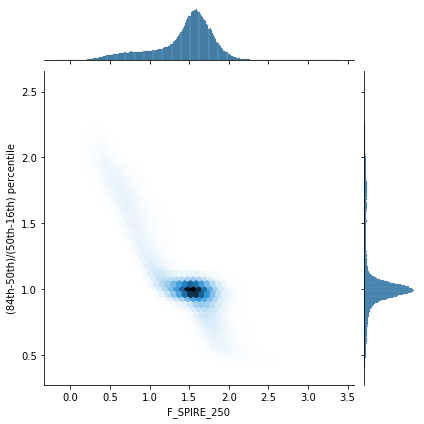

In [5]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')

For 250 $\mathrm{\mu m}$ depth is ~ 10mJy

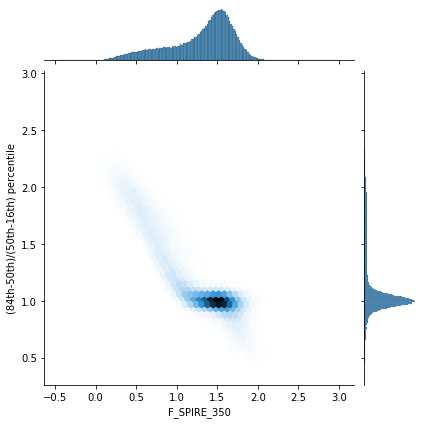

In [6]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')


For 350 $\mathrm{\mu m}$ depth is ~ 10mJy

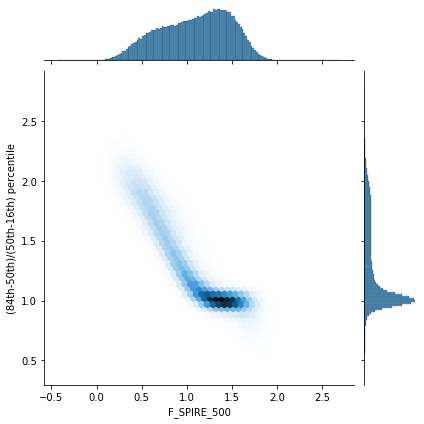

In [7]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')


For 500 $\mathrm{\mu m}$ depth is ~ 10mJy

## Add flag to catalogue

In [8]:
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [9]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 10)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 10)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 10)

In [10]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

69120 76089 109627 232589


In [11]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [12]:
# set XID+ cahtalogue back to orignal order of objects, as used in MF detection files
use = cat['HELP_ID'].astype(int) -1
use = np.argsort(use)
cat = cat[use]

## Investigate Background, $\sigma_{confusion}$ and cirrus
Herschel Stripe 82 suffers from cirrus contamination. Because xid+ fits the background and confusion noise, this can compensate and consider the contamination. The next series of plots show whether this is actually happening.

Text(0.5, 0, 'Sig_conf_SPIRE_500')

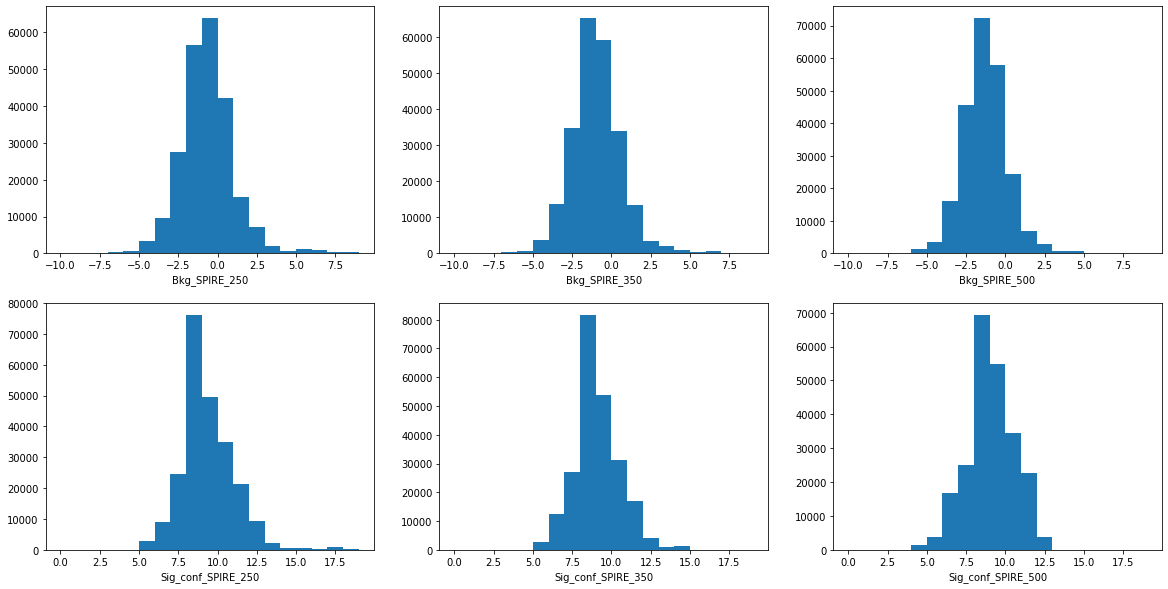

In [73]:
fig,axes=plt.subplots(2,3,figsize=(20,10))

axes[0,0].hist(cat['Bkg_SPIRE_250'],bins=np.arange(-10,10));
axes[0,0].set_xlabel('Bkg_SPIRE_250')
axes[0,1].hist(cat['Bkg_SPIRE_350'],bins=np.arange(-10,10));
axes[0,1].set_xlabel('Bkg_SPIRE_350')
axes[0,2].hist(cat['Bkg_SPIRE_500'],bins=np.arange(-10,10));
axes[0,2].set_xlabel('Bkg_SPIRE_500')


axes[1,0].hist(cat['Sig_conf_SPIRE_250'],bins=np.arange(0,20));
axes[1,1].hist(cat['Sig_conf_SPIRE_350'],bins=np.arange(0,20));
axes[1,2].hist(cat['Sig_conf_SPIRE_500'],bins=np.arange(0,20));
axes[1,0].set_xlabel('Sig_conf_SPIRE_250')
axes[1,1].set_xlabel('Sig_conf_SPIRE_350')
axes[1,2].set_xlabel('Sig_conf_SPIRE_500')



The plot above shows the 1d histograms for background and $\sigma_{confusion}$ for all SPIRE bands

In [46]:
#because of where Herschel Stripe 82 is in sky (i.e. traverses 360, 0 degree) need to come ip with work aroundfor plotting
t=cat['RA'].copy()

In [47]:
t[t>100]=t[t>100]-360

Text(0.5, 1.0, 'Sig_conf_SPIRE_500')

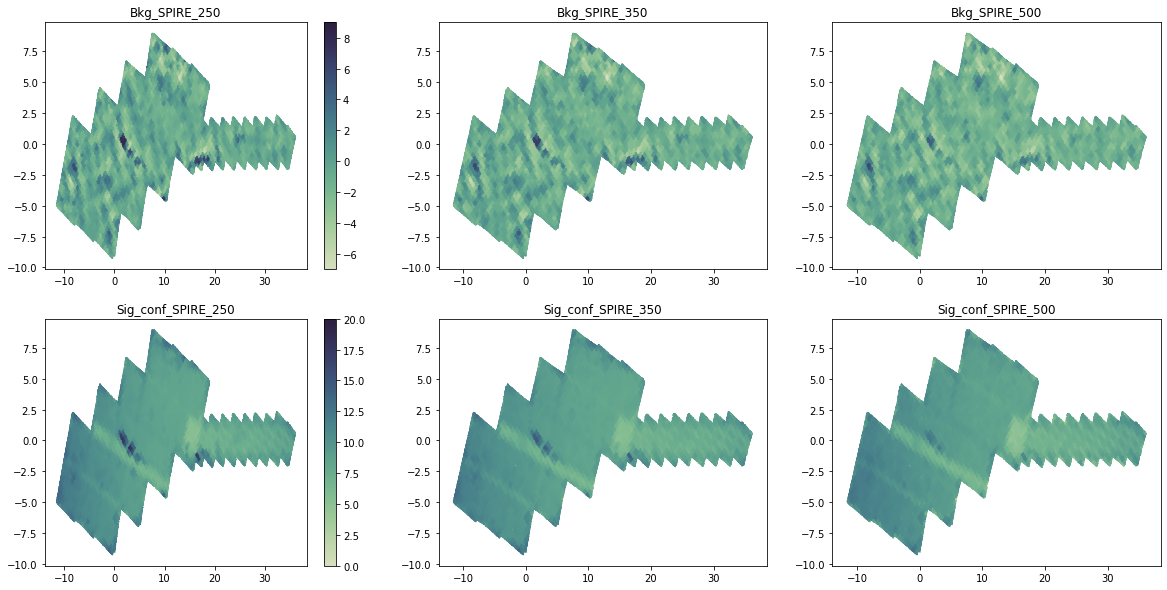

In [70]:
fig,axes=plt.subplots(2,3,figsize=(20,10))
a=axes[0,0].scatter(t,cat['Dec'],c=cat['Bkg_SPIRE_250'],vmin=-7,vmax=9,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
fig.colorbar(a, ax=axes[0,0])
axes[0,0].set_title('Bkg_SPIRE_250')
axes[0,1].set_title('Bkg_SPIRE_350')
axes[0,2].set_title('Bkg_SPIRE_500')

axes[0,1].scatter(t,cat['Dec'],c=cat['Bkg_SPIRE_350'],vmin=-7,vmax=9,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
axes[0,2].scatter(t,cat['Dec'],c=cat['Bkg_SPIRE_500'],vmin=-7,vmax=9,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
axes[1,0].scatter(t,cat['Dec'],c=cat['Sig_conf_SPIRE_250'],vmin=0,vmax=20,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
axes[1,1].scatter(t,cat['Dec'],c=cat['Sig_conf_SPIRE_350'],vmin=0,vmax=20,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
b=axes[1,2].scatter(t,cat['Dec'],c=cat['Sig_conf_SPIRE_500'],vmin=0,vmax=20,s=0.1,
                  cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True));
fig.colorbar(b, ax=axes[1,0])
axes[1,0].set_title('Sig_conf_SPIRE_250')
axes[1,1].set_title('Sig_conf_SPIRE_350')
axes[1,2].set_title('Sig_conf_SPIRE_500')


The plot above shows the background and $\sigma_{confusion}$ noise values for all the catalogue sources. As expected, there is higher background and confusion noise values on the areas we know there is cirrus. Because xid+ has taken the cirrus into account via background and confusion noise parameters, and marginalised over them, the flux values for each object should be less effected by the cirrus.

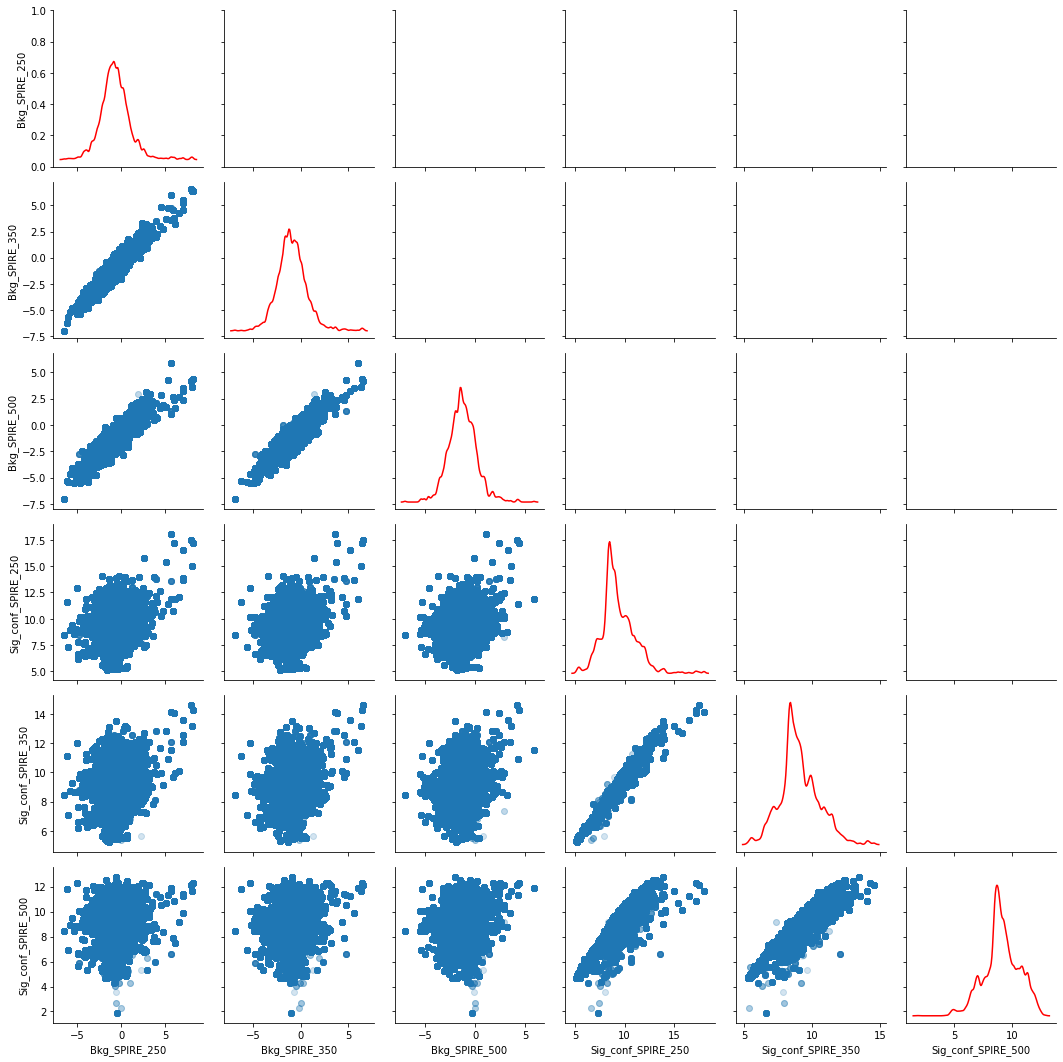

In [86]:
g=sns.PairGrid(cat[['Bkg_SPIRE_250','Bkg_SPIRE_350','Bkg_SPIRE_500','Sig_conf_SPIRE_250','Sig_conf_SPIRE_350','Sig_conf_SPIRE_500']].to_pandas())
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(plt.scatter,alpha=0.1)

The plot above shows the pair-pair plots for background and confusion noise for all three bands. Note a slight correlation for high background and hogh confusion noise, indicating these tiles had cirrus contamination.

## Read in MF table

In [14]:
# Reads MF table, removes duplicate RA and DEC
cat2=Table.read('./data/Herschel-Stripe-82_SPIRE_all.fits')
print('# galaxies = ',np.size(cat2['RA']))
print('# galaxies = ',np.size(cat['RA']))
del cat2['RA']
del cat2['Dec']
cat_all = hstack([cat,cat2])

# galaxies =  232589
# galaxies =  232589


In [15]:
# Created HELP_ID, and changes HELP to HELP_BLIND to avoid confusion with HELP-Masterlist objects
ID = gen_help_id(cat_all['RA'], cat_all['Dec'])
ID_new = [IDs.replace('HELP','HELP_BLIND') for IDs in ID]
ID_new = Column(ID_new,name="HELP_ID")
cat_all['HELP_ID'] = ID_new

In [16]:
# all flux denisties are in mJy in the final BLIND catalogues
cat_all['F_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_250'] = 1000*cat_all['F_BLIND_MF_SPIRE_250']
cat_all['FErr_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_250'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_250']

cat_all['F_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_350'] = 1000*cat_all['F_BLIND_MF_SPIRE_350']
cat_all['FErr_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_350'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_350']

cat_all['F_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_500'] = 1000*cat_all['F_BLIND_MF_SPIRE_500']
cat_all['FErr_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_500'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_500']

cat_all['F_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['F_BLIND_pix_SPIRE'] = 1000*cat_all['F_BLIND_pix_SPIRE']
cat_all['FErr_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['FErr_BLIND_pix_SPIRE'] = 1000*cat_all['FErr_BLIND_pix_SPIRE']


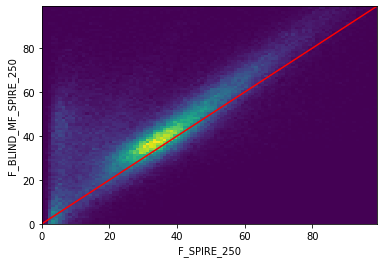

In [34]:
# XID+ flux density vs. MF flux densities
plt.hist2d(cat_all['F_SPIRE_250'],cat_all['F_BLIND_MF_SPIRE_250'],bins=np.arange(0,100))
plt.plot([0,100],[0,100], color = 'red')
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.xlabel('F_SPIRE_250')
plt.ylabel('F_BLIND_MF_SPIRE_250')
plt.show()


In [19]:
# Add field name
cat_all.add_column(Column(['Herschel-Stripe-82']*len(cat_all),name='field'))


In [20]:
cat_all.write('./data/dmu22_XID+SPIRE_Herschel-Stripe-82_BLIND_Matched_MF.fits', format='fits',overwrite=True)

## Check Bayesian P value maps

In [97]:
from astropy.io import fits
psw=fits.open('./data/dmu22_XID+SPIRE_psw_Herschel-Stripe-82_Bayes_Pval_20201207.fits',memmap=True)
pmw=fits.open('./data/dmu22_XID+SPIRE_pmw_Herschel-Stripe-82_Bayes_Pval_20201207.fits',memmap=True)
plw=fits.open('./data/dmu22_XID+SPIRE_plw_Herschel-Stripe-82_Bayes_Pval_20201207.fits',memmap=True)

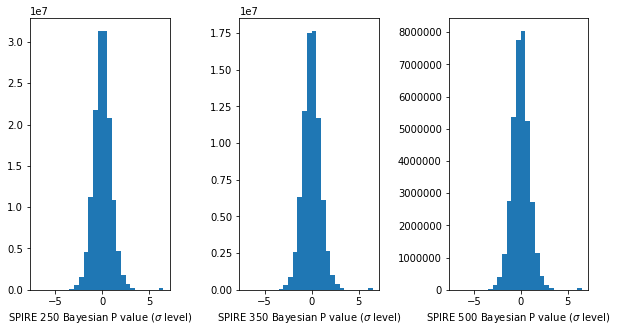

In [107]:
fig,axes=plt.subplots(1,3,figsize=(10,5))
axes[0].hist(psw[1].data.flatten(),np.arange(-7,7,0.5));
axes[0].set_xlabel('SPIRE 250 Bayesian P value ($\sigma$ level)')
axes[1].hist(pmw[1].data.flatten(),np.arange(-7,7,0.5));
axes[1].set_xlabel('SPIRE 350 Bayesian P value ($\sigma$ level)')
axes[2].hist(plw[1].data.flatten(),np.arange(-7,7,0.5));
axes[2].set_xlabel('SPIRE 500 Bayesian P value ($\sigma$ level)')
plt.subplots_adjust(wspace=0.5)

Histograms from Bayesian P value maps are all centred around 0 (which is good), with slight positive tails, suggesting some pixels have more flux in than the model can explain (also expected likely due to e.g. extended sources, or sources not included in the flux cut)

#### SPIRE 250 Bayesian P value map
No obvious issues

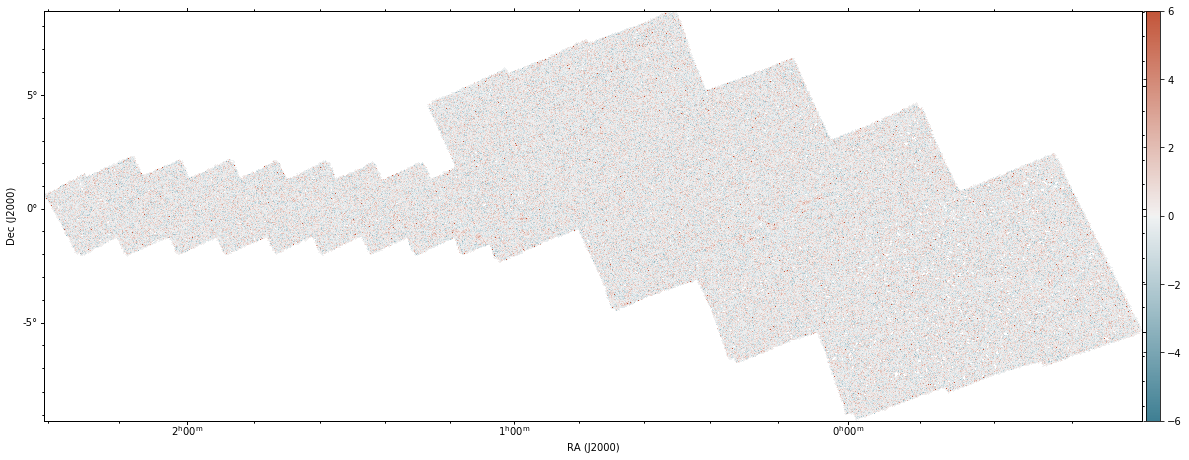

In [99]:
import aplpy
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig=aplpy.FITSFigure(psw[1],figsize=(20,10))
fig.show_colorscale(vmin=-6, vmax=6, cmap=cmap)
fig.add_colorbar()

#### SPIRE 350 Bayesian P value map
No obvious issues

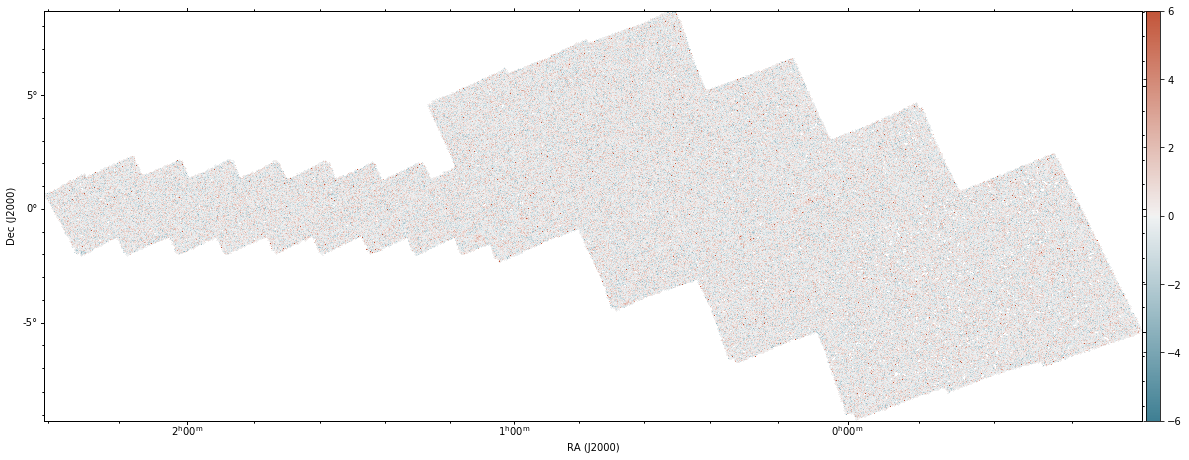

In [100]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig=aplpy.FITSFigure(pmw[1],figsize=(20,10))
fig.show_colorscale(vmin=-6, vmax=6, cmap=cmap)
fig.add_colorbar()

#### SPIRE 500 Bayesian P value map
No obvious issues

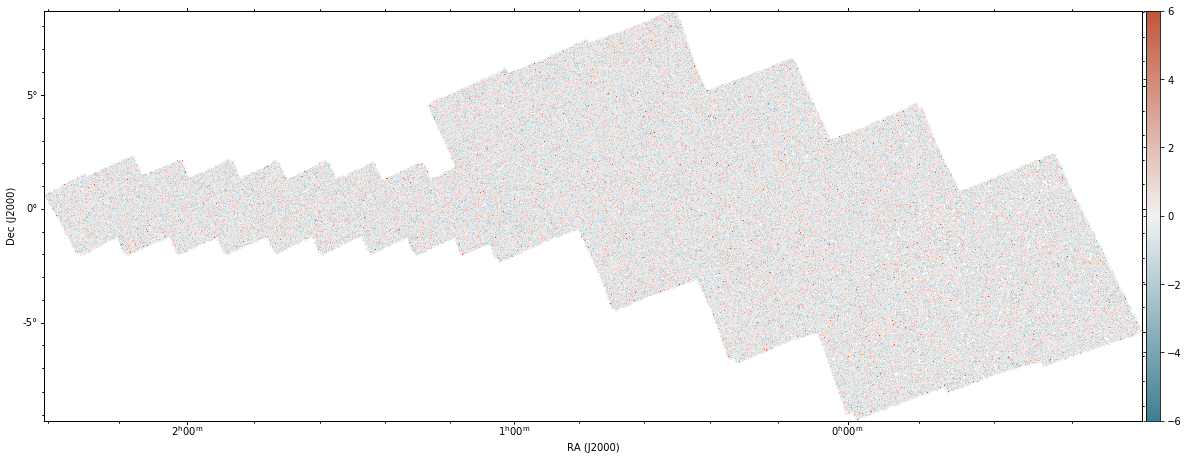

In [101]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig=aplpy.FITSFigure(plw[1],figsize=(20,10))
fig.show_colorscale(vmin=-6, vmax=6, cmap=cmap)
fig.add_colorbar()

*This is a default HELP jupyter notebook *

 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)

**Authors**: P.D. Hurley, S. Duivenvoorden

 
For a full description of the database and how it is organised in to `dmu_products` please the top level [readme](../readme.md).
 
The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)